# КЛАССИФИКАЦИЯ ГОСКОНТРАКТОВ ПО ОБЪЕКТАМ ЗАКУПКИ

## Описание задачи
### Задача: необходимо на основе данных с ftp.zakupki.gov.ru научиться определять группу, к которой относится контракт с кодом ОКПД-2 41, 42, 43, 71.1.

Группы могут быть следующими:
1. Строительно-монтажные работы (СМР)
2. Проектно-изыскательские работы (ПИР)
3. Строительный надзор
4. Подключение коммуникаций
5. Прочее.

По ОКПД-2 контракты в общем случае должны разделяться так:
- Строительно-монтажные работы (СМР) - 41, 42, 43(кроме нижеперечисленных)
- Проектно-изыскательские работы (ПИР) - 41.1, 71.1
- Подключение коммуникаций - 43.22
- Строительный надзор – четкой группы нет.

**Проблема**: Далеко не всегда контракты указываются с нужным кодом, поэтому есть проблема как такие контракты "отловить" и определить в нужную группу. Поэтому задача предполагает классификацию контрактов на основе объекта закупки, который сформулирован естественным языком. Также предполагаем, что могут иметь значение цена контракта и его длительность.

На основе этого на входе данные о контрактах. На выходе необходимо получить группу для каждого контракта. Иногда контракт может относиться одновременно в несколько групп. В приложении ниже пример нескольких контрактов, у которых неверно проставлен ОКПД-2.

---

## Содержание

Предыдущий файл: **Глава 1. Предобработка данных**

## Глава 2. Модели

4. [Загрузка обработанных данных и EDA](#4.-Загрузка-обработанных-данных-и-EDA)

- 4.1. [Импорт данных](#4.1.-Импорт-данных)
- 4.2. [Разделение данных на train, valid, test](#4.2.-Разделение-данных-на-train,-valid,-test)

5. [Создание моделей](#5.-Создание-моделей)

- 5.1. [Baseline модель (Начальная модель). TF IDF и Логистическая регрессия](#5.1.-Baseline-модель-(Начальная-модель).-TF-IDF-и-Логистическая-регрессия)
- 5.2. [TF IDF и Random Forest](#5.2.-TF-IDF-и-Random-Forest)
- 5.3. [Мешок Слов BagOfWords + RandomForest](#5.3.-Мешок-Слов-BagOfWords-+-RandomForest)
- 5.4. [Сложная модель](#5.4.-Сложная-модель)
- 5.4.1. [Словарь слов](#5.4.1.-Словарь-слов)
- 5.4.2. [RNN Реккурентная нейронная сеть](#5.4.2.-RNN-Реккурентная-нейронная-сеть)
- 5.4.3. [LSTM](#5.4.3.-LSTM)
- 5.5. [Предобученные эмбеддинги FastText и лемматизация](#5.5.-Предобученные-эмбеддинги-FastText-и-лемматизация)
- 5.5.1. [FastText + LSTM](#5.5.1.-FastText-+-LSTM)
- 5.5.2. [FastText + лемматизация Mystem + LSTM](#5.5.2.-FastText-+-лемматизация-Mystem-+-LSTM)

6. [Заключение](#6.-Заключение)


---

### Контакты

Собченко Анастасия Алексеевна, email: lobzinastya@gmail.com 

Ранее, в главе 0 была произведена подготовка и обработка данных ("0_Предобработка_данных.ipynb"), в результате которых есть файл с датасетом df0. Вся работа данной главы по созданию моделей классификации будет осуществляться с этим датасетом

# 4. Загрузка обработанных данных и EDA

## 4.1. Импорт данных

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df0 = pd.read_csv('df0.csv', index_col=0)
df0.sample(10, random_state = 10)

,text,duration,sum,okpd
0,,,,
1383673,"Выполнение работ по разработке проектно-сметной документации по благоустройству территории, расположенной по адресу: г.Москва, ЗАО, район Филевский парк, придомовая территория по ул. Новозаводская",15.0,2454360.77,71.1
503416,Выполнение работ по ремонту кровельного покрытия,7.0,1377000.00,41.2
587146,Выполнение работ по капитальному ремонту асфальтобетонного покрытия дорог в городе Боровск 2016 год (Реестровый номер: 805Э-02/16сб),13.0,11470841.59,42.1
870684,"Оказание услуг по благоустройству и озеленению территорий, прилегающих к административным зданиям Правительства Тверской области, для нужд ГБУ «УЭОАЗП» на 2017 год",15.0,4915949.82,71.1
2251621,Выполнение комплекса работ по содержанию муниципальных автомобильных дорог общего пользования местного значения Заветинского района Ростовской области в 2018 году,15.0,500000.00,42.1
447681,"Снятие, поверка и монтаж приборов учета тепловой энергии, горячего и холодного водоснабжения",7.0,84384.67,43.2
984882,Выполнение работ по обеспечению безопасности дорожного движения на территории городского округа Рошаль в 2017 году,15.0,873610.00,42.1
579515,Выполнение работ по модернизации конференц-системы зала заседаний Волгоградской городской Думы,13.0,8574521.32,43.2
997355,Образование 30 (тридцати) земельных участков из земель государственная собственность на которые не разграничена,7.0,74400.00,71.1


In [3]:
#из предыдущей главы
okpd_dict = {'43.2': 'Работы строительные специализированные',
             '71.1': 'Услуги в области архитектуры и инженерно-технического проектирования, технических испытаний, исследований и анализа',
             '42.1': 'Сооружения и строительные работы в области гражданского строительства',
             '41.2': 'Здания и работы по возведению зданий'}

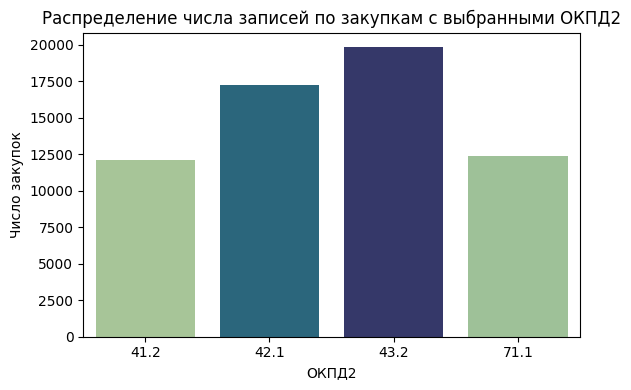

,okpd,count,percentage%
0,41.2,12079,19.62
1,42.1,17243,28.01
2,43.2,19843,32.24
3,71.1,12392,20.13


In [4]:
df0_statistics = pd.DataFrame(df0.groupby(by=['okpd'])['text'].count()).reset_index().rename(columns = {'text':'count'})
df0_statistics['percentage%'] = np.round(100*df0_statistics['count'] / df0.shape[0],2)

plt.figure(figsize=(6, 4))
sns.barplot(data=df0_statistics, x="okpd", y="count", hue='count', palette='crest', legend=False)
plt.title("Распределение числа записей по закупкам с выбранными ОКПД2", fontsize=12)
plt.xlabel("ОКПД2", fontsize=10)
plt.ylabel("Число закупок", fontsize=10)
plt.tight_layout()
plt.show()

pd.set_option('display.max_colwidth', None)
df0_statistics

Будем считать, что в итоге мы получили достаточно равномерное распределение данных по классам

С помощью LabelEncoder кодируем метки наших классов

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df0['label'] = label_encoder.fit_transform(df0['okpd'])

labels_dict = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Словарь окпд2=метка класса ", labels_dict)

Словарь окпд2=метка класса  {41.2: 0, 42.1: 1, 43.2: 2, 71.1: 3}


In [6]:
label2okpdname = {j: okpd_dict[str(i)] for i,j in labels_dict.items()}
print("Словарь метка класса: расшифровка ОКПД ")
print(*label2okpdname.items(), sep='\n')

Словарь метка класса: расшифровка ОКПД 
(0, 'Здания и работы по возведению зданий')
(1, 'Сооружения и строительные работы в области гражданского строительства')
(2, 'Работы строительные специализированные')
(3, 'Услуги в области архитектуры и инженерно-технического проектирования, технических испытаний, исследований и анализа')


In [7]:
df0.head(10)

,text,duration,sum,okpd,label
0,,,,,
394,прочая закупка услуг (услуги по монтажу и пусконаладке вытяжных систем вентиляции в производственных помещениях раскройного участка швейного цеха),14.0,248515.44,43.2,2
460,выполнение работ по монтажу средств тревожной сигнализации в зданиях Стерлитамакского филиала БашГУ,15.0,485952.92,43.2,2
501,"Текущий ремонт туалета, части инженерных сетей цокольного этажа Медицинского колледжа ФГБОУ ВО БГМУ Минздрава России",14.0,564534.54,41.2,0
1212,Замена труб отопления,7.0,142000.00,43.2,2
1242,Оказание услуг по техническому обслуживанию и регламентно-профилактический ремонт индивидуальных тепловых пунктов,7.0,688555.00,43.2,2
1243,Оказание услуг по техническому обслуживанию лифтов,7.0,132000.00,43.2,2
1379,Выполнение кадастровых работ и постановку на кадастровый учет зданий,15.0,169150.00,71.1,3
1553,Капитальный ремонт санузла Лакской межрайонной прокуратуры Республики Дагестан,17.0,205003.00,41.2,0
1554,Капитальный ремонт санузла прокуратуры Рутульского района Республики Дагестан,17.0,200480.00,41.2,0


In [8]:
# еще раз проверка на отсутствующие значения
df0.isna().sum()

text        0
duration    0
sum         0
okpd        0
label       0
dtype: int64

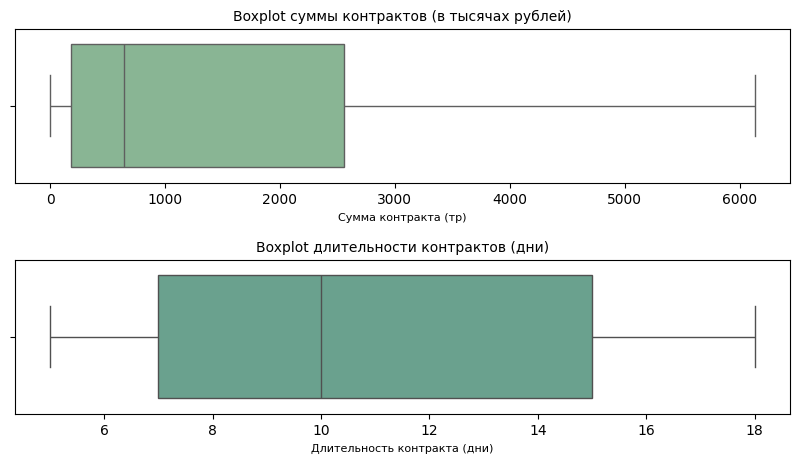

In [9]:
colors = sns.color_palette('crest', n_colors=7)

plt.figure(figsize = (10, 5))

plt.subplot(2,1,1)
sns.boxplot(x = df0['sum']/1000,  showfliers=False, color = colors[0]) #выбросы не показываем, их слишком много(
plt.title('Boxplot суммы контрактов (в тысячах рублей)', fontsize=10)
plt.xlabel('Сумма контракта (тр)', fontsize=8)


plt.subplot(2,1,2)
sns.boxplot(x = df0['duration'], showfliers=True, color = colors[1], flierprops={'marker':'o', 'markerfacecolor':'red', 'markersize':3, 'alpha':0.7})
plt.title('Boxplot длительности контрактов (дни)', fontsize=10)
plt.xlabel('Длительность контракта (дни)', fontsize=8)

plt.subplots_adjust(hspace=0.5)  
plt.show()


В данных по сумме контрактов - выбросов очень много. Для визуализации выше принято решение их не показывать. 

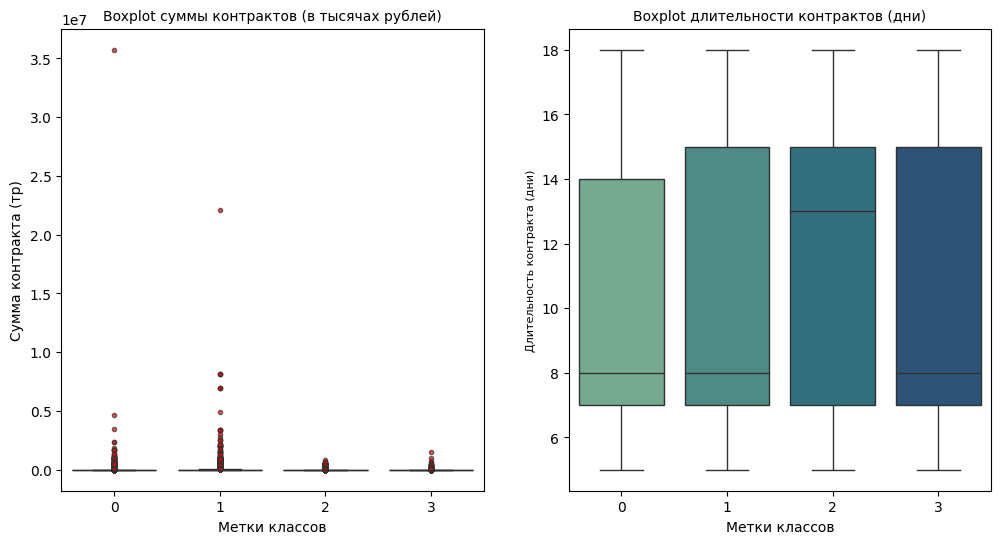

In [10]:
plt.figure(figsize = (12, 6))

plt.subplot(1,2,1)
sns.boxplot(y = df0['sum']/1000, x=df0['label'], 
            showfliers=True, 
            flierprops={'marker':'o', 'markerfacecolor':'red', 'markersize':3, 'alpha':0.7}, 
            palette = 'crest') #с выбросами
plt.title('Boxplot суммы контрактов (в тысячах рублей)', fontsize=10)
plt.ylabel('Сумма контракта (тр)', fontsize=10)
plt.xlabel('Метки классов', fontsize=10)

plt.subplot(1,2,2)

sns.boxplot(y = df0['duration'], x= df0['label'], showfliers=True, palette='crest', flierprops={'marker':'o', 'markerfacecolor':'red', 'markersize':3, 'alpha':0.7})
plt.title('Boxplot длительности контрактов (дни)', fontsize=10)
plt.ylabel('Длительность контракта (дни)', fontsize=8)

plt.xlabel('Метки классов', fontsize=10)

plt.show()

## 4.2. Разделение данных на train, valid, test

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = df0.drop(columns = ['okpd','label'])
y = df0['label']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle = True, random_state =33)
X_valid, X_test, y_valid, y_test= train_test_split(X_valid, y_valid, test_size=0.5, random_state = 33)

print('Обучающая выборка, размеры X_train, y_train: ', X_train.shape, y_train.shape)
print('Валидационная выборка, размеры X_valid, y_valid: ', X_valid.shape, y_valid.shape)
print('Тестовая выборка, размеры X_test, y_test: ', X_test.shape, y_test.shape)

Обучающая выборка, размеры X_train, y_train:  (49245, 3) (49245,)
Валидационная выборка, размеры X_valid, y_valid:  (6156, 3) (6156,)
Тестовая выборка, размеры X_test, y_test:  (6156, 3) (6156,)


In [13]:
print('Пропорции классов в обучающей выборке:')
print(y_train.value_counts(normalize=True))
print('Пропорции классов в валидационной выборке:')
print(y_valid.value_counts(normalize=True))
print('Пропорции классов в тестовой выборке:')
print(y_test.value_counts(normalize=True))

Пропорции классов в обучающей выборке:
label
2    0.322490
1    0.278526
3    0.203330
0    0.195654
Name: proportion, dtype: float64
Пропорции классов в валидационной выборке:
label
2    0.322450
1    0.284276
0    0.197693
3    0.195582
Name: proportion, dtype: float64
Пропорции классов в тестовой выборке:
label
2    0.321150
1    0.288661
0    0.199318
3    0.190871
Name: proportion, dtype: float64


Будем собирать все данные о моделях и их результатах в отдельную таблицу results

Как понятно из названия - обучающую выборку будем использовать для обучения моделей. Валидационную часть - в случае подбора гиперпараметров модели. Тестовую выборку для проверки метрики качества (но в случае, когда валидационные данные не были использованы для тюннинга моделей, будем считать и точность на валидационной выборке).

Как показано ранее, наши классы были достаточно сбалансированы. По этой причине, в качестве оценки модели будем использовать метрику точность - accuracy (то есть доля правильно классифицированных объектов), а также дополнительно метрику f1 (среднее геометрическое между recall и precision, причем во взвешенной вариации f1 weighted, учитывающей количество экземпляров классов)



In [14]:
results = pd.DataFrame({}, columns = ['Модель', 'Детали (описание модели)', 'Accuracy_valid', 'Accuracy_test', 'F1_test','Best_params'])
results

,Модель,Детали (описание модели),Accuracy_valid,Accuracy_test,F1_test,Best_params


Функция для визуализации матрицы ошибок:

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def my_confusion_matrix(y_test, y_pred, model, model_name):
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='crest', values_format='')
    plt.title(f'Матрица ошибок для модели {model_name}', fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Предсказанные метки', fontsize=12)
    plt.ylabel('Истинные метки', fontsize=12)
    plt.grid(False)
    plt.show()

# 5. Создание моделей

## 5.1. Baseline модель (Начальная модель). TF IDF и Логистическая регрессия

Построим начальный пайплайн модели для решения нашей задачи классификации:
- Преобразование данных preprocessor

Числовые данные (duration - длительность контракта, sum - сумма контракта) нормализуем с помощью StandardScaler()

Текстовые данные (text - объект закупки) преобразуем в числовое представление с помощью TfidfVectorizer()

- Модель: Так как у нас 4 класса мы не смогли бы просто использовать базовую логистическую регрессию. Возьмем в качестве классификатора OneVsRestClassifier, что позволяет моделировать многоклассовую задачу, где каждый класс (метка) рассматривается отдельно (против всех остальных vs rest).

В ходе обучения будем использовать только обучающую выборку train (никакого подбора гиперпараметров с помощью валидационной выборки, таким образом получим оценку качества независимую и на valid и на test данных)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score,  f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['duration', 'sum']),
        ('text', TfidfVectorizer(), 'text')
    ])


logistic_model = LogisticRegression(max_iter=1000)
model = OneVsRestClassifier(logistic_model)

pipeline_baseline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

pipeline_baseline.fit(X_train, y_train)
pipeline_baseline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['duration', 'sum']),
                                                 ('text', TfidfVectorizer(),
                                                  'text')])),
                ('model',
                 OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000)))])

Подробнее про работу модели с текстовыми данными:

Текстовые данные (text) в пайплане преобразуются в числовое представление с помощью TfidfVectorizer() (Term Frequency-Inverse Document Frequency (TF-IDF)), который учитывает частоту слов в документе (Term Frequency, TF ) и их значимость в документах (Обратная частота документа Inverse Document Frequency, IDF).

В результате получается матрица tfidf_df, где строки соответствуют "документам" (то есть записям об объекте закупки "text"), а столбцы — уникальным токенам. Значения в этой матрице и есть  значения TF-IDF.

In [18]:
tfidf_transformed = pipeline_baseline.named_steps['preprocessor'].transform(X_train)
tfidf_vectorizer = pipeline_baseline.named_steps['preprocessor'].transformers_[1][1]
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_matrix = tfidf_transformed[:, len(X_train.columns)-1:].toarray()
tfidf_df = pd.DataFrame(tfidf_matrix, columns=tfidf_feature_names)

pd.set_option('display.max_columns', 100)
print('Матрица TF-IDF размерность [число_записей_train, число_токенов]: ', tfidf_df.shape)
tfidf_df.head(5)

Матрица TF-IDF размерность [число_записей_train, число_токенов]:  (49245, 38363)


,00,000,0000,000000,0000000,00000006,0000001,0000001950,00000024,00000053,00000055,000001011048,000001011157,000001200002,000001211435,0000031,0000037,000003710,000016390,000016430,000025,000097850,000097880,000099740,0000а,000100470,000104210,0004,000685750,000685950,0007,0008,000а,001,001001,0010112,0010240,0010326,0010437,0010905,0011306,001216,001220,002,0020101,0020202,0020205,0020338,0020501,0020801,...,ясногорск,ясногорска,ясногорске,ясногорский,ясногорского,ясное,яснозоринском,яснополянское,яснур,ясные,ясный,ястребовского,ятчи,яуза,яузская,яуши,ях,яха,яхе,яхрома,яхромская,яхромского,яхтенной,яценко,ячеек,ячейка,ячейки,яшалта,яшалтинского,яшалтинском,яшина,яшкино,яшкинская,яшкинского,яшкинское,яшкинском,яшкуль,ящики,ящиков,яя,ёвдино,ёгла,ёлка,ёлки,ёлкин,ёлкинский,ёлок,ёлочка,ёль,ёрмица
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Пример 
ii = 4242
print('Объект закупки: ',X_train['text'].iloc[ii])
print('\nНенулевые столбцы с токенами:\n', tfidf_df.iloc[ii][tfidf_df.iloc[ii]>0])

Объект закупки:  Поверка узла учета тепловой энергии в СП ГБУЗ \ЧОКПТД\""

Ненулевые столбцы с токенами:
 гбуз        0.250842
поверка     0.354661
сп          0.394563
тепловой    0.273365
узла        0.310041
учета       0.260963
чокптд      0.584514
энергии     0.273864
Name: 4242, dtype: float64


In [20]:
# Предсказания на ваидационной и тестовой выборке, оценка качества

y_pred_valid = pipeline_baseline.predict(X_valid)
y_pred_test = pipeline_baseline.predict(X_test)

acc_valid = accuracy_score(y_valid, y_pred_valid)
acc_test = accuracy_score(y_test, y_pred_test)


print(f'Точность на валидационной выборке: {acc_valid:.4f}')
print(f'Точность на тестовой выборке: {acc_test:.4f}')

f1_weighted = f1_score(y_test, y_pred_test, average='weighted')
print(f'F1(weighted) на тестовой выборке: {f1_weighted:.4f}')

Точность на валидационной выборке: 0.9228
Точность на тестовой выборке: 0.9207
F1(weighted) на тестовой выборке: 0.9207


In [21]:
results.loc[len(results)] = [
    'Baseline',
    'TF-IDF + Логистическая регрессия (OneVsRestClassifier)',
    acc_valid,
    acc_test,
    f1_weighted,
    None
]
results

,Модель,Детали (описание модели),Accuracy_valid,Accuracy_test,F1_test,Best_params
0,Baseline,TF-IDF + Логистическая регрессия (OneVsRestClassifier),0.92284,0.920728,0.920702,None


Так как для этой и нескольких следующих моделей, где не используется валидационная часть датасета для подбора гиперпараметров и обучения (обучение только на train) можно считать, что точность будем в некотором диапазоне получившихся значений Accuracy_valid - Accuracy_test	

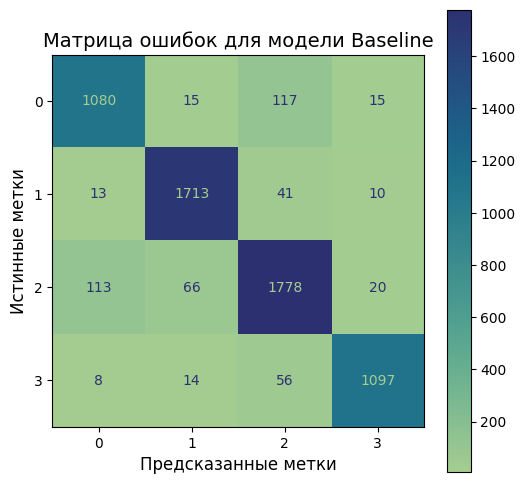

In [22]:
my_confusion_matrix(y_test, y_pred_test, pipeline_baseline.named_steps['model'], 'Baseline')

### Интрепретация результатов. Важность признаков

Так как в пайплайне в качестве модели используется вариация логистической регрессии (по сути 4 модели для каждого класса), важности признаков (то есть числовых duration, sum и каждого из токенов получившейся матрицы tf-idf) могут быть оценены как коэффициенты линейной регресиии. Визуализацию топ признаков будем строить с учетом модуля коэффициента, и для каждого из классов

In [23]:
lrovr_model = pipeline_baseline.named_steps['model']

# tfidf_vectorizer = pipeline_baseline.named_steps['preprocessor'].transformers_[1][1]
# tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

coef_dict = {}
for i, model in enumerate(lrovr_model.estimators_):
    coef_dict[f'Класс {i}'] = model.coef_[0][:len(tfidf_feature_names)]  

coef_df = pd.DataFrame(coef_dict, index=tfidf_feature_names)

num_features = ['duration', 'sum']
num_coef_df = pd.DataFrame(index=num_features)

for i, model in enumerate(lrovr_model.estimators_):
    numeric_coefs = model.coef_[0][-len(num_features):]
    num_coef_df[f'Класс {i}'] = numeric_coefs

final_coef_df = pd.concat([coef_df, num_coef_df])

final_coef_df

,Класс 0,Класс 1,Класс 2,Класс 3
00,-0.011136,-0.053043,0.038820,-0.016999
000,0.055045,0.235746,-0.636586,-0.877852
0000,-0.518996,1.387046,-0.771810,-0.423839
000000,-0.721391,0.308640,-2.255785,1.551075
0000000,-0.243147,0.077091,0.421186,-0.138398
...,...,...,...,...
ёлочка,-0.212947,-0.003038,0.070734,0.128816
ёль,-0.008344,-0.066343,0.102574,-0.023357
ёрмица,0.376008,-0.022410,-0.309133,-0.013436
duration,-0.006690,0.092215,-0.026628,-0.026865


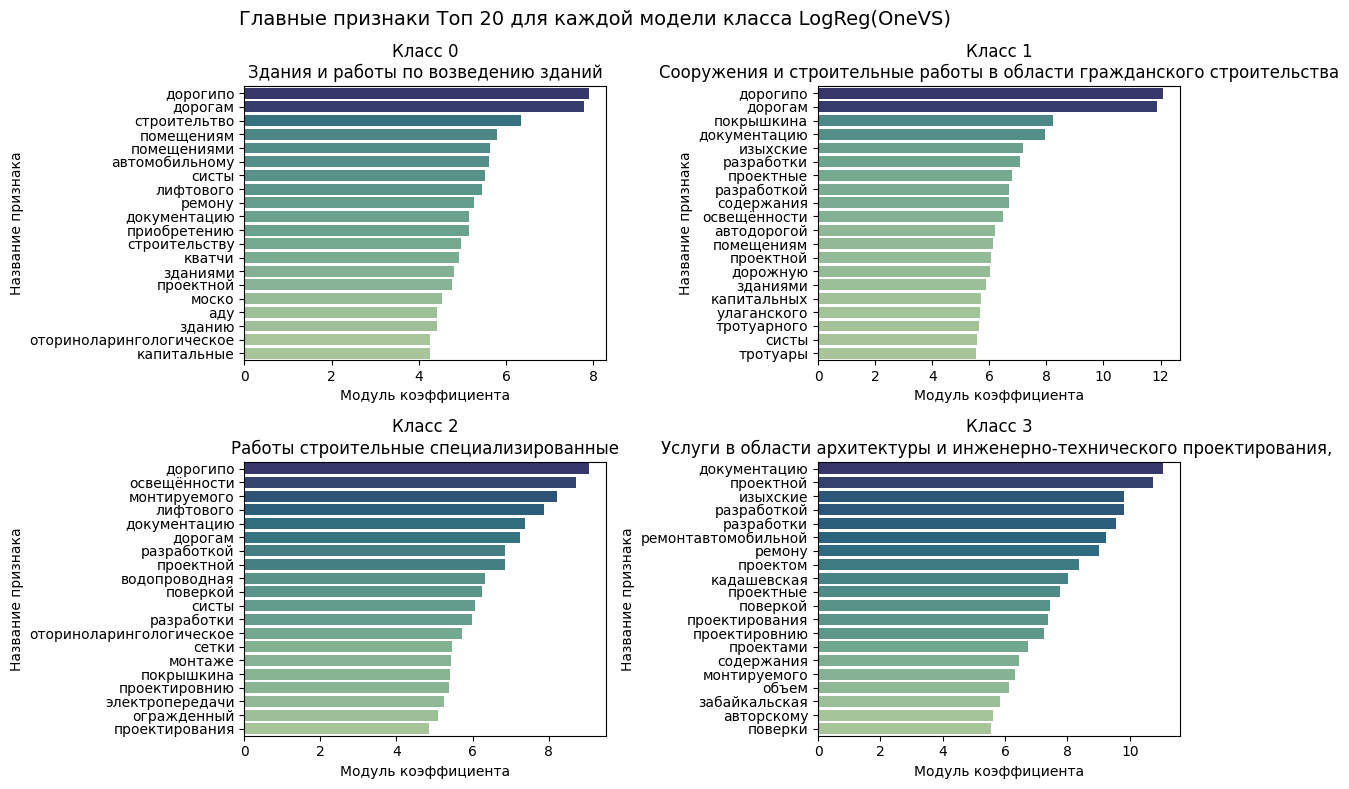

In [24]:
top_n = 20


plt.figure(figsize=(12, 8))

for i in range(final_coef_df.shape[1]):
    plt.subplot(2, 2, i + 1)
    abs_coefs = final_coef_df.iloc[:, i].abs()
    top_features = abs_coefs.nlargest(top_n).index
    top_values = abs_coefs.nlargest(top_n).values

    sns.barplot(y = top_features, x = top_values, hue = top_values, palette = 'crest', legend = False)
    plt.title(f'Класс {i}\n{label2okpdname[i][:70]}', fontsize=12)
    plt.xlabel('Модуль коэффициента')
    plt.ylabel('Название признака')

plt.suptitle(f'Главные признаки Топ {top_n} для каждой модели класса LogReg(OneVS)', fontsize=14)
plt.tight_layout()
plt.show()

Как видно из топов признаков ни для одной модели (то есть класса) числовые признаки duration, sum не попали в главные 20 признаков логистических реггрессий, только отдельные токены получившихся tf-idf

## 5.2. TF-IDF и Random Forest

Модифицируем наш пайплайн

Будем использовать для текстовых данных все тот же TfidfVectorizer, но вместо логистической регрессии и подхода OnevsRest используем в пайплайне модель RandomForest. Мы могли бы обойтись без нормализации числовых данных duration и sum, так как это не требуется для моделей random forest, но оставим структуру пайплайна и препроцессора прежней

In [25]:
%%time
from sklearn.ensemble import RandomForestClassifier


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['duration', 'sum']),
        ('text', TfidfVectorizer(), 'text')
    ]
)

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    verbose=1
)

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

pipeline_rf.fit(X_train, y_train)
pipeline_rf


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   22.5s


CPU times: user 45.3 s, sys: 203 ms, total: 45.5 s
Wall time: 46.2 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['duration', 'sum']),
                                                 ('text', TfidfVectorizer(),
                                                  'text')])),
                ('model', RandomForestClassifier(random_state=42, verbose=1))])

In [26]:
y_pred_valid = pipeline_rf.predict(X_valid)
y_pred_test = pipeline_rf.predict(X_test)

acc_valid = accuracy_score(y_valid, y_pred_valid)
acc_test = accuracy_score(y_test, y_pred_test)


print(f'Точность на валидационной выборке: {acc_valid:.4f}')
print(f'Точность на тестовой выборке: {acc_test:.4f}')


f1_weighted = f1_score(y_test, y_pred_test, average='weighted')
print(f'F1(weighted) на тестовой выборке: {f1_weighted:.4f}')

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Точность на валидационной выборке: 0.9246
Точность на тестовой выборке: 0.9214
F1(weighted) на тестовой выборке: 0.9215


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


In [27]:
results.loc[len(results)] = [
    'Модель 2',
    'TfIdf + RandomForest. Обучение на train',
    acc_valid,
    acc_test,
    f1_weighted,
    None
]
results

,Модель,Детали (описание модели),Accuracy_valid,Accuracy_test,F1_test,Best_params
0,Baseline,TF-IDF + Логистическая регрессия (OneVsRestClassifier),0.922840,0.920728,0.920702,None
1,Модель 2,TfIdf + RandomForest. Обучение на train,0.924626,0.921378,0.921521,None


Как видно из таблицы results использование random forest вместо многоклассового подхода и логистической регрессии незначительно улучшило наши метрики качества (опять смотрим на оба показателя, Accuracy_valid	Accuracy_test, так как обучение было только на train) и f1

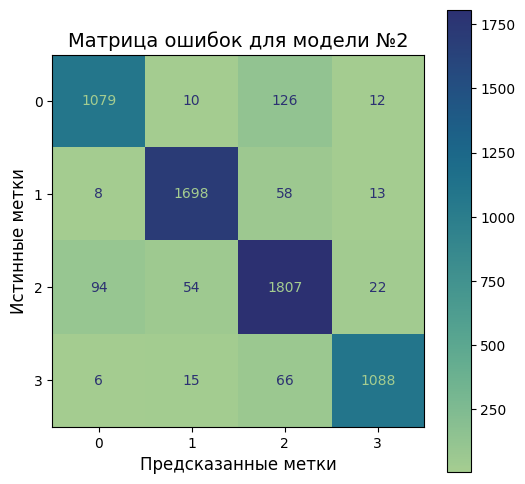

In [28]:
my_confusion_matrix(y_test, y_pred_test, pipeline_rf.named_steps['model'], '№2')

### Важность признаков

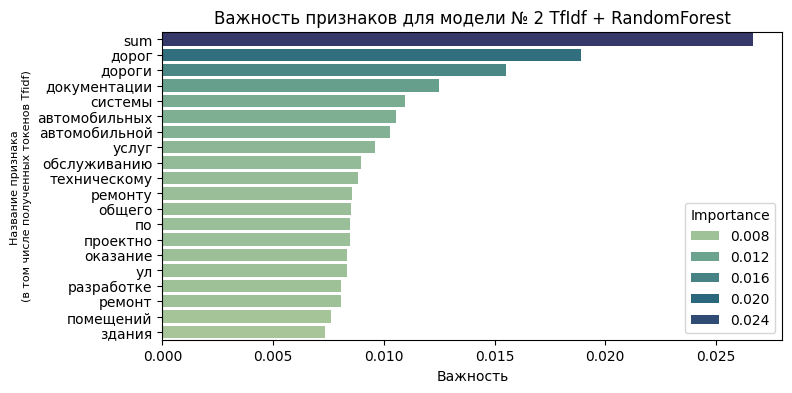

Самые важные признаки (топ 20):


,Feature,Importance
1,sum,0.026668
11254,дорог,0.018904
11261,дороги,0.015505
11092,документации,0.012496
30203,системы,0.010943
3701,автомобильных,0.010544
3693,автомобильной,0.010290
34501,услуг,0.009614
22435,обслуживанию,0.008967
32918,техническому,0.008820


In [29]:
rf_model = pipeline_rf.named_steps['model']
importances = rf_model.feature_importances_

numeric_features = ['duration', 'sum']
tfidf_vectorizer = pipeline_rf.named_steps['preprocessor'].transformers_[1][1]
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
all_features = np.hstack([numeric_features, tfidf_feature_names])

feature_importances_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

top_n = 20

plt.figure(figsize=(8, 4))
sns.barplot(y = feature_importances_df[:top_n]['Feature'], x = feature_importances_df[:top_n]['Importance'], hue = feature_importances_df[:top_n]['Importance'], palette='crest')
plt.title('Важность признаков для модели № 2 TfIdf + RandomForest')
plt.ylabel('Название признака \n(в том числе полученных токенов Tfidf)', fontsize=8)
plt.xlabel('Важность')
plt.show()

print(f'Самые важные признаки (топ {top_n}):')
feature_importances_df.head(top_n)


## 5.3. Мешок Слов BagOfWords + RandomForest

Испробуем другой подход к обработке текстовых данных. Теперь в нашем пайплайне вместо tf-idf будем использовать мешок слов (Bag of Words, BoW), а именно CountVectorizer (считает количество вхождений каждого слова без учета частоты документа). В качестве модели классификации оставим RandomForest

In [30]:
from sklearn.feature_extraction.text import CountVectorizer 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['duration', 'sum']),  
        ('text', CountVectorizer(), 'text') 
    ]
)

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    verbose=1
)

pipeline_bow_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

pipeline_bow_rf.fit(X_train, y_train)
pipeline_bow_rf

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   26.5s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['duration', 'sum']),
                                                 ('text', CountVectorizer(),
                                                  'text')])),
                ('model', RandomForestClassifier(random_state=42, verbose=1))])

In [31]:
# подробнее про получившееся векторное представления для мешка слов: вывод ненулевых токенов для конкретной строки примера

count_vectorizer = pipeline_bow_rf.named_steps['preprocessor'].transformers_[1][1]
X_bow_transformed = count_vectorizer.transform(X_train['text'])
bow_df = pd.DataFrame(X_bow_transformed.toarray(), columns=count_vectorizer.get_feature_names_out())

ii = 4242
print('Объект закупки: ', X_train['text'].iloc[ii])
print('\nНенулевые столбцы с токенами:\n', bow_df.iloc[ii][bow_df.iloc[ii] > 0])


Объект закупки:  Поверка узла учета тепловой энергии в СП ГБУЗ \ЧОКПТД\""

Ненулевые столбцы с токенами:
 гбуз        1
поверка     1
сп          1
тепловой    1
узла        1
учета       1
чокптд      1
энергии     1
Name: 4242, dtype: int64


In [32]:
y_pred_valid = pipeline_bow_rf.predict(X_valid)
y_pred_test = pipeline_bow_rf.predict(X_test)

acc_valid = accuracy_score(y_valid, y_pred_valid)
acc_test = accuracy_score(y_test, y_pred_test)


print(f'Точность на валидационной выборке: {acc_valid:.4f}')
print(f'Точность на тестовой выборке: {acc_test:.4f}')


f1_weighted = f1_score(y_test, y_pred_test, average='weighted')
print(f'F1(weighted) на тестовой выборке: {f1_weighted:.4f}')

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Точность на валидационной выборке: 0.9256
Точность на тестовой выборке: 0.9227
F1(weighted) на тестовой выборке: 0.9228


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


In [33]:
results.loc[len(results)] = [
    'Модель 3',
    'BoW + RandomForest. Обучение на train',
    acc_valid,
    acc_test,
    f1_weighted,
    None
]
results

,Модель,Детали (описание модели),Accuracy_valid,Accuracy_test,F1_test,Best_params
0,Baseline,TF-IDF + Логистическая регрессия (OneVsRestClassifier),0.922840,0.920728,0.920702,None
1,Модель 2,TfIdf + RandomForest. Обучение на train,0.924626,0.921378,0.921521,None
2,Модель 3,BoW + RandomForest. Обучение на train,0.925601,0.922677,0.922813,None


Подход с Bag of Words мешком слов + случайный лес по метрикам показал себя лучше, чем TfIdf + RandomForest.

### Интерпретация важности признаков

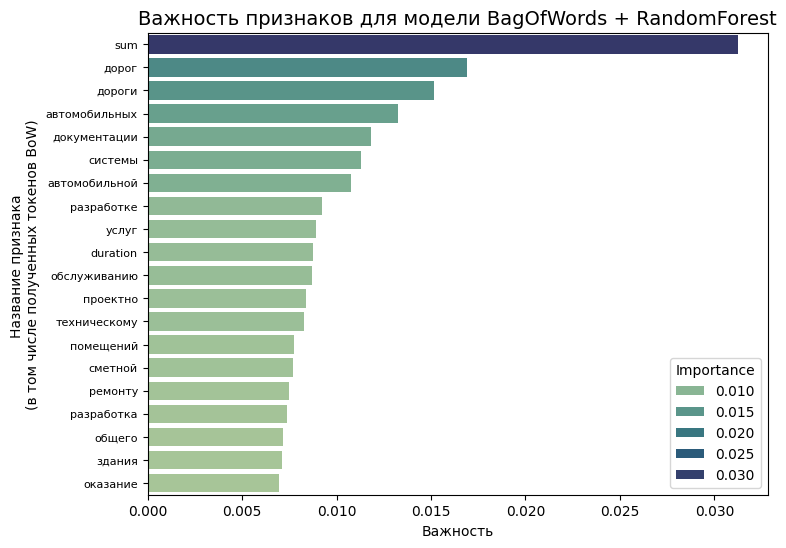

Самые важные признаки (топ 20):


,Feature,Importance
1,sum,0.031251
11254,дорог,0.016906
11261,дороги,0.015184
3701,автомобильных,0.013233
11092,документации,0.011845
30203,системы,0.011273
3693,автомобильной,0.010764
27748,разработке,0.009233
34501,услуг,0.008931
0,duration,0.008757


In [34]:
rf_model = pipeline_bow_rf.named_steps['model']
importances = rf_model.feature_importances_
numeric_features = ['duration', 'sum']
count_vectorizer = pipeline_bow_rf.named_steps['preprocessor'].transformers_[1][1]
bow_feature_names = count_vectorizer.get_feature_names_out()
all_features = np.hstack([numeric_features, bow_feature_names])

feature_importances_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

top_n = 20
plt.figure(figsize=(8, 6))
sns.barplot(y=feature_importances_df[:top_n]['Feature'], 
            x=feature_importances_df[:top_n]['Importance'], 
            hue=feature_importances_df[:top_n]['Importance'], 
            palette='crest')
plt.title('Важность признаков для модели BagOfWords + RandomForest', fontsize=14)
plt.ylabel('Название признака \n(в том числе полученных токенов BoW)', fontsize=10)
plt.xlabel('Важность', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)
plt.show()

print(f'Самые важные признаки (топ {top_n}):')
feature_importances_df.head(top_n)


Как мы видим duration и sum для данной модели попали в топ 20 важных признаков. Но конечно модель BoW породила такое большое количество токенов, а значит настолько увеличилось общее количество признаков, что важность каждого признака очень маленькая (даже для самых важных

## 5.4. Сложная модель

### 5.4.1. Словарь слов 

Из имеющегося датасета создаем словарь слов, выбираем 30000 наиболее встречающихся, создаем векторные представления этих слов и дальше используем реккурентную нейронную сеть для обработки данных

In [35]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

from collections import Counter
from typing import List


# import nltk
# nltk.download('punkt')

import re
import string

Обрабатываем все текстовые данные. Убираем пунктуацию, приводим к нижнему регистру, убираем цифры. Токенизируем

In [36]:
objects = []

for sentence in tqdm(df0['text']):
    sentence = re.sub(r'[^\w\s]', ' ', sentence.lower())
    tokens = word_tokenize(sentence, language='russian')
    filtered_tokens = [token for token in tokens if token.isalpha()]
    objects.append(tokens)

print("Всего предложений:", len(objects))
print('Пример токенизированного: ',objects[101])

  0%|          | 0/61557 [00:00<?, ?it/s]

Всего предложений: 61557
Пример токенизированного:  ['оказание', 'услуг', 'по', 'содержанию', 'искусственных', 'сооружений', 'на', 'автомобильной', 'дороге', 'а', '376', 'хабаровск', 'лидога', 'ванино', 'комсомольск', 'на', 'амуре', 'хабаровский', 'край']


In [37]:
words = Counter()

for obj in tqdm(objects):
    for word in obj:
        words[word] += 1

print('Всего слов:', len(words))
print('Топ 10 встречающихся слов', *words.most_common(10))

  0%|          | 0/61557 [00:00<?, ?it/s]

Всего слов: 42448
Топ 10 встречающихся слов ('по', 50419) ('в', 33391) ('работ', 27115) ('выполнение', 25630) ('и', 25318) ('на', 19780) ('ул', 15172) ('ремонт', 12057) ('ремонту', 11378) ('г', 10573)


Создем словарь vocab и два словаря для преобразования между словами и их индексами

In [38]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 30000
words_common = set(word for word,_ in words.most_common(vocab_size))
vocab = vocab.union(words_common)

word2ind = {w: i for i, w in enumerate(vocab)}
ind2word = {i: w for w, i in word2ind.items()}

Класс FullDataset, который представляет собой структуру данных для обработки текстовых и числовых данныхи подготовки их к обучению модели. Код включает в себя метод для получения данных из набора и функцию для группировки данных с учетом паддинга.


In [39]:
class FullDataset:
    def __init__(self, data, word2ind=word2ind, has_labels = True):
        self.data = data
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']
        self.word2ind = word2ind
        self.has_labels = has_labels

    def __getitem__(self, idx: int) -> dict:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation)
        )

        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            self.word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text, language="russian")
            if not word.isdigit()
        ]
        tokenized_sentence += [self.eos_id]

        if self.has_labels:

          train_sample = {
              "text": tokenized_sentence,
              "label": self.data[idx]['label'],
              "duration": self.data[idx]['duration'],  
              "sum": self.data[idx]['sum']  
          }
        else:
          train_sample = {
                "input_ids": tokenized_sentence,
                "duration": self.data[idx]['duration'],  
                "sum": self.data[idx]['sum'] 
            }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(input_batch, word2ind = word2ind, pad_id=None, max_len=256):
    if pad_id is None:
        pad_id = word2ind['<pad>']
    if 'text' in input_batch[0]:
        seq_lens = [len(x['text']) for x in input_batch]  
        new_batch_text = [x['text'] for x in input_batch]
    else:
        seq_lens = [len(x['input_ids']) for x in input_batch]  
        new_batch_text = [x['input_ids'] for x in input_batch]

    max_seq_len = min(max(seq_lens), max_len)

    padded_batch_text = []
    new_batch_duration = []
    new_batch_sum = []
    labels = []

    for i, sequence in enumerate(input_batch):
        text = new_batch_text[i][:max_seq_len]
        text += [pad_id] * (max_seq_len - len(text))  

        padded_batch_text.append(text)
        new_batch_duration.append(sequence['duration'])
        new_batch_sum.append(sequence['sum'])

        if 'label' in sequence:
            labels.append(sequence['label'])

    sequences = torch.LongTensor(padded_batch_text).to(device)
    durations = torch.FloatTensor(new_batch_duration).to(device)
    sums = torch.FloatTensor(new_batch_sum).to(device)

    if labels:
        labels = torch.LongTensor(labels).to(device)
        return {
            'input_ids': sequences,
            'duration': durations,
            'sum': sums,
            'label': labels
        }
    else:
        return {
            'input_ids': sequences,
            'duration': durations,
            'sum': sums
        }


In [ ]:
#такое же разбиение как было для простых моделей по random seed, но тут в даталоадеры идут и label из-за организации структуры функции evaluation
train_dataset, valid_dataset = train_test_split(df0.drop(columns=['okpd']), test_size=0.2, shuffle = True, random_state = 33)
valid_dataset, test_dataset = train_test_split(valid_dataset, test_size=0.5, random_state = 33)

print('Обучающая выборка, train_dataset: ', train_dataset.shape)
print('Валидационная выборка, valid_dataset: ', valid_dataset.shape)
print('Тестовая выборка, test_dataset: ', test_dataset.shape)

In [41]:
train_dataset = FullDataset(train_dataset.to_dict(orient='records'), word2ind)
eval_dataset = FullDataset(valid_dataset.to_dict(orient='records'), word2ind)
test_dataset = FullDataset(test_dataset.to_dict(orient='records'), word2ind)


batch_size = 32
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [42]:
import seaborn as sns

sns.set(style="darkgrid")
paired_colors = sns.color_palette("Paired", 4)
paired_colors


def results_viz(model_name, num_epoch, acc_type, losses_type, best_params, output_name=None):
    """
    Визуализация результатов
    """
    epochs = np.arange(num_epoch)

    plt.figure(figsize = (12,4))

    plt.subplot(1,2,1)
    for (i, name) in enumerate(list(acc_type.keys())):
        accuracies=np.array(acc_type[name]) * 100
        acc_train, acc_valid = accuracies.T

        plt.plot(epochs, acc_train, color=paired_colors[i*2], label=f"{name} - train", marker='o', markersize=4, linewidth=2.5)
        plt.plot(epochs, acc_valid, color=paired_colors[i*2+1], label=f"{name} - valid", marker='o', markersize=4, linewidth=2.5)

        if best_params['aggregation_type'] == name:
            plt.text(best_params['epoch'], max(acc_valid)+0.2, f'{max(acc_valid):.2f}', fontsize=10, color=paired_colors[i*2+1], ha='center')
        print(f"Лучшая accuracy для подхода {name}: {max(acc_valid):.2f} valid, {max(acc_train):.2f} train")
    plt.title('Accuracy (Точность)')
    plt.xlabel("Epoch (Эпоха обучения)")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.75))
    plt.xticks(epochs, labels=[f'{epoch:.0f}' for epoch in epochs], fontsize=8)


    plt.subplot(1,2,2)
    for (i, name) in enumerate(list(losses_type.keys())):
        losses = losses_type[name]
        plt.plot(np.arange(len(losses)), losses, color=paired_colors[i*2], label=name, marker='o', markersize=4, linewidth=2.5)
    plt.title('Losses (Функция потери)')
    plt.xlabel("Epoch (Эпоха обучения)")
    plt.ylabel("Loss")
    plt.suptitle(model_name)
    plt.xticks(epochs, labels=[f'{epoch:.0f}' for epoch in epochs], fontsize=8)

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    if output_name:
        plt.savefig(f'{output_name}.png')

    plt.show()

#Про визуализацию
# Эпохи (n) нумеруются  0...n-1
# Подразумевается, что результаты Accuracy\Losses считаются один раз в конце эпохи


In [43]:
def evaluate(model, eval_dataloader) -> float:
    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model({
                'input_ids': batch['input_ids'],
                'duration': batch['duration'],
                'sum': batch['sum']
            })
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy, predictions


In [44]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используемое устройство: {device}")

Используемое устройство: mps


### 5.4.2. RNN Реккурентная нейронная сеть 

In [45]:
class FullWordLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
    ):
        super().__init__()


        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.text_linear = nn.Linear(hidden_dim, hidden_dim)

        self.numeric_linear = nn.Linear(2, hidden_dim)  # 2 признака: duration и sum
        self.projection = nn.Linear(hidden_dim * 2, num_classes)  # Увеличили размерность для текста + числовых признаков
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch['input_ids'])  # [batch_size, seq_len, hidden_dim]
        rnn_output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            rnn_output = rnn_output.max(dim=1)[0]  # [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            rnn_output = rnn_output.mean(dim=1)  # [batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        text_features = self.dropout(self.text_linear(self.non_lin(rnn_output)))  # [batch_size, hidden_dim]


        numeric_features = torch.stack([input_batch['duration'], input_batch['sum']], dim=1)  # [batch_size, 2]
        numeric_features = self.dropout(self.non_lin(self.numeric_linear(numeric_features)))  # [batch_size, hidden_dim]
        combined_features = torch.cat([text_features, numeric_features], dim=1)  # [batch_size, hidden_dim * 2]
        prediction = self.projection(self.non_lin(combined_features))  # [batch_size, num_classes]

        return prediction


Обучение для типа аггрегации max


Эпоха обучения 0:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 0, valid_accuracy 0.9173


Эпоха обучения 1:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 1, valid_accuracy 0.9202


Эпоха обучения 2:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 2, valid_accuracy 0.9269


Эпоха обучения 3:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 4:   0%|          | 0/1539 [00:00<?, ?it/s]

Обучение для типа аггрегации mean


Эпоха обучения 0:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 1:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 2:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 3:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 4:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 92.69 valid, 96.94 train
Лучшая accuracy для подхода mean: 91.98 valid, 94.68 train


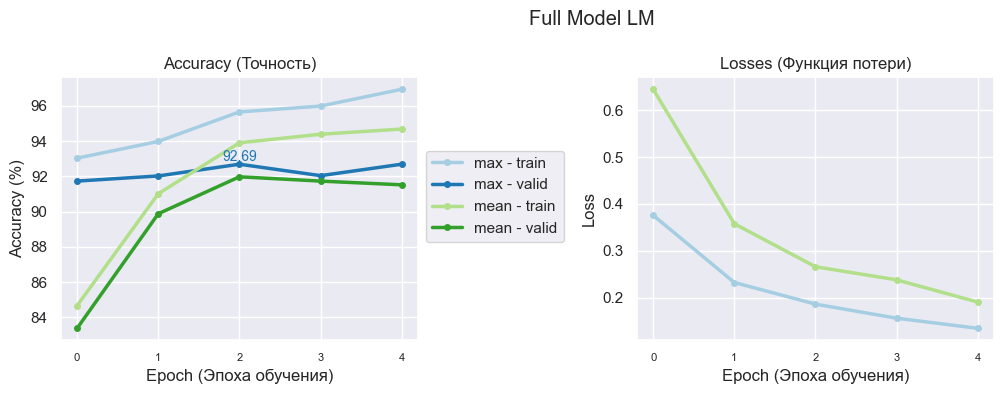

In [46]:
num_epoch = 5
best_eval_acc = float('-inf')
best_model_state = None
save_path = f"best_model.pt"
best_params = {'aggregation_type': None, 'epoch': None}

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Обучение для типа аггрегации {aggregation_type}")
    losses, acc = [], []
    model = FullWordLM(hidden_dim=256, num_classes=len(labels_dict), vocab_size=len(vocab),aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Эпоха обучения {epoch}')):
            optimizer.zero_grad()
            logits = model({'input_ids': batch['input_ids'],'duration': batch['duration'],'sum': batch['sum']})
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        model.eval()
        current_accuracy_valid, _ = evaluate(model, eval_dataloader)
        current_accuracy_train, _ = evaluate(model, train_dataloader)
        acc.append([current_accuracy_train, current_accuracy_valid])

        if current_accuracy_valid > best_eval_acc:
            best_eval_acc = current_accuracy_valid
            best_model_state = model.state_dict()
            torch.save(best_model_state, save_path)
            print(f"Лучшая модель сохранена: эпоха {epoch}, valid_accuracy {best_eval_acc:.4f}")
            best_params['aggregation_type'] = aggregation_type
            best_params['epoch'] = epoch

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

results_viz('Full Model LM', num_epoch, acc_type, losses_type, best_params)

(Мы восстанавливаем лучшее состояние весов исходя из максимальной точности на валидационном датасете)

In [47]:
model_full = FullWordLM(hidden_dim=256, num_classes = len(labels_dict), vocab_size=len(vocab), aggregation_type=best_params['aggregation_type']).to(device)
# save_path = f"best_model.pt"
model_full.load_state_dict(torch.load(save_path, weights_only=True))
model_full.eval()

accuracy_valid,_ = evaluate(model_full, eval_dataloader)
accuracy_test, predictions_test = evaluate(model_full, test_dataloader)

print(f'Точность на валидационной выборке: {accuracy_valid:.4f}')
print(f'Точность на тестовой выборке: {accuracy_test:.4f}')

predictions_test = predictions_test.tolist()
f1_weighted = f1_score(y_test, predictions_test, average='weighted')
print(f'F1(weighted) на тестовой выборке: {f1_weighted:.4f}')

print(f"\nЛучшая модель FullWordLM - лучшие параметры: aggregation_type {best_params['aggregation_type']}, epoch {best_params['epoch']}")




Точность на валидационной выборке: 0.9269
Точность на тестовой выборке: 0.9144
F1(weighted) на тестовой выборке: 0.9143

Лучшая модель FullWordLM - лучшие параметры: aggregation_type max, epoch 2


In [48]:
results.loc[len(results)] = [
    'Модель RNN',
    'Свой словарь + RNN. Использование valid',
    accuracy_valid,
    accuracy_test,
    f1_weighted,
    best_params
]
results

,Модель,Детали (описание модели),Accuracy_valid,Accuracy_test,F1_test,Best_params
0,Baseline,TF-IDF + Логистическая регрессия (OneVsRestClassifier),0.922840,0.920728,0.920702,None
1,Модель 2,TfIdf + RandomForest. Обучение на train,0.924626,0.921378,0.921521,None
2,Модель 3,BoW + RandomForest. Обучение на train,0.925601,0.922677,0.922813,None
3,Модель RNN,Свой словарь + RNN. Использование valid,0.926901,0.914392,0.914336,"{'aggregation_type': 'max', 'epoch': 2}"


Как мы видим полученная модель работает даже хуже своих простых аналогов. Но мы улучшим ее работу, просто заменив RNN модуль сети на LSTM (Long Short Term Memory), чтобы модель лучше обрабатывала тестовые последовательности и хранила больше информации о контекстах

### 5.4.3. LSTM 

Визуализация архитектуры получившейся сети (с помощью onnx)
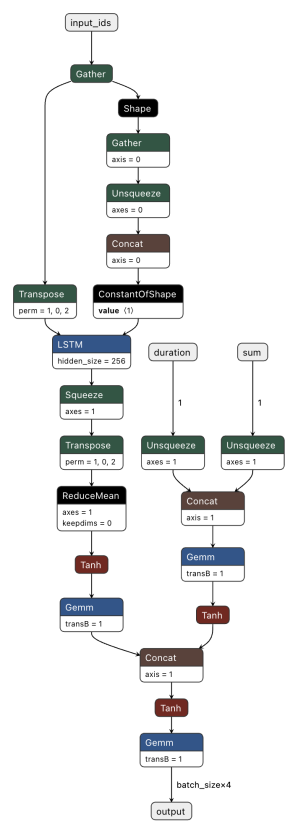


In [49]:
class FullWordLM_LSTM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.text_linear = nn.Linear(hidden_dim, hidden_dim)

        self.numeric_linear = nn.Linear(2, hidden_dim)  # 2 признака: duration и sum
        self.projection = nn.Linear(hidden_dim * 2, num_classes)  # Увеличили размерность для текста + числовых признаков
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch['input_ids'])  # [batch_size, seq_len, hidden_dim]
        rnn_output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            rnn_output = rnn_output.max(dim=1)[0]  # [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            rnn_output = rnn_output.mean(dim=1)  # [batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        text_features = self.dropout(self.text_linear(self.non_lin(rnn_output)))  # [batch_size, hidden_dim]
        numeric_features = torch.stack([input_batch['duration'], input_batch['sum']], dim=1)  # [batch_size, 2]
        numeric_features = self.dropout(self.non_lin(self.numeric_linear(numeric_features)))  # [batch_size, hidden_dim]
        combined_features = torch.cat([text_features, numeric_features], dim=1)  # [batch_size, hidden_dim * 2]
        prediction = self.projection(self.non_lin(combined_features))  # [batch_size, num_classes]

        return prediction


Обучение для типа аггрегации max


Эпоха обучения 0:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 0, valid_accuracy 0.9251


Эпоха обучения 1:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 1, valid_accuracy 0.9352


Эпоха обучения 2:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 3:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 4:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 4, valid_accuracy 0.9368
Обучение для типа аггрегации mean


Эпоха обучения 0:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 1:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 2:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 3:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 4:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 93.68 valid, 98.73 train
Лучшая accuracy для подхода mean: 93.13 valid, 98.64 train


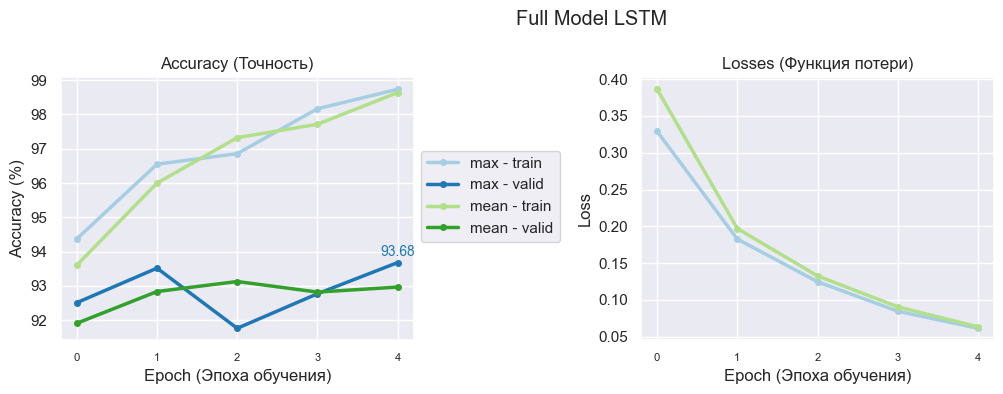

In [50]:
num_epoch = 5
best_eval_acc = float('-inf')
best_model_state = None
save_path = f"best_model.pt"
best_params = {'aggregation_type': None, 'epoch': None}

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Обучение для типа аггрегации {aggregation_type}")
    losses, acc = [], []
    model = FullWordLM_LSTM(hidden_dim=256, num_classes=len(labels_dict), vocab_size=len(vocab),aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Эпоха обучения {epoch}')):
            optimizer.zero_grad()
            logits = model({'input_ids': batch['input_ids'],'duration': batch['duration'],'sum': batch['sum']})
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        model.eval()
        current_accuracy_valid,_ = evaluate(model, eval_dataloader)
        current_accuracy_train,_ = evaluate(model, train_dataloader)
        acc.append([current_accuracy_train, current_accuracy_valid])

        if current_accuracy_valid > best_eval_acc:
            best_eval_acc = current_accuracy_valid
            best_model_state = model.state_dict()
            torch.save(best_model_state, save_path)
            print(f"Лучшая модель сохранена: эпоха {epoch}, valid_accuracy {best_eval_acc:.4f}")
            best_params['aggregation_type'] = aggregation_type
            best_params['epoch'] = epoch

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

results_viz('Full Model LSTM', num_epoch, acc_type, losses_type, best_params)

In [51]:
model_full_lstm = FullWordLM_LSTM(hidden_dim=256, num_classes = len(labels_dict), vocab_size=len(vocab), aggregation_type=best_params['aggregation_type']).to(device)
# save_path = f"best_model.pt"
model_full_lstm.load_state_dict(torch.load(save_path, weights_only=True))
model_full_lstm.eval()

accuracy_valid,_ = evaluate(model_full_lstm, eval_dataloader)
accuracy_test, predictions_test = evaluate(model_full_lstm, test_dataloader)



print(f'Точность на валидационной выборке: {accuracy_valid:.4f}')
print(f'Точность на тестовой выборке: {accuracy_test:.4f}')

predictions_test = predictions_test.tolist()
f1_weighted = f1_score(y_test, predictions_test, average='weighted')
print(f'F1(weighted) на тестовой выборке: {f1_weighted:.4f}')

print(f"\nЛучшая модель FullWordLM LSTM - лучшие параметры: aggregation_type {best_params['aggregation_type']}, epoch {best_params['epoch']}")


Точность на валидационной выборке: 0.9368
Точность на тестовой выборке: 0.9256
F1(weighted) на тестовой выборке: 0.9255

Лучшая модель FullWordLM LSTM - лучшие параметры: aggregation_type max, epoch 4


In [52]:
results.loc[len(results)] = [
    'Модель LSTM',
    'Свой словарь + LSTM. Использование valid',
    accuracy_valid,
    accuracy_test,
    f1_weighted,
    best_params
]
results

,Модель,Детали (описание модели),Accuracy_valid,Accuracy_test,F1_test,Best_params
0,Baseline,TF-IDF + Логистическая регрессия (OneVsRestClassifier),0.922840,0.920728,0.920702,None
1,Модель 2,TfIdf + RandomForest. Обучение на train,0.924626,0.921378,0.921521,None
2,Модель 3,BoW + RandomForest. Обучение на train,0.925601,0.922677,0.922813,None
3,Модель RNN,Свой словарь + RNN. Использование valid,0.926901,0.914392,0.914336,"{'aggregation_type': 'max', 'epoch': 2}"
4,Модель LSTM,Свой словарь + LSTM. Использование valid,0.936810,0.925601,0.925499,"{'aggregation_type': 'max', 'epoch': 4}"


Исходя из полученных результатов эта модель с LSTM стала лучшей! Именно такую архитектуру мы будем разворачивать для нашего приложения

Однако конечно есть способ еще улучшить модель - в том числе попробовать использовать не просто векторные представления слов, а предобученные эмбеддинги

## 5.5. Предобученные эмбеддинги FastText и лемматизация 

In [53]:
import fasttext
import torch
from nltk.tokenize import word_tokenize
import string
from torch.utils.data import Dataset, DataLoader


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

from collections import Counter
from typing import List


# import nltk
# nltk.download('punkt')

import re
import string



FastText — это библиотека для обработки естественного языка (NLP), разработанная командой Facebook AI Research (FAIR). Используем предобученные эмбеддинги для русского языка.

In [54]:
fasttext_model = fasttext.load_model('cc.ru.300.bin')

### 5.5.1. FastText + LSTM

In [55]:
class ModifiedDatasetFT(Dataset):
    def __init__(self, data, embedding_model, has_labels=True):
        self.data = data
        self.model = embedding_model
        self.has_labels = has_labels

    def get_word_embedding(self, word):
        # Получаем эмбеддинг для слова
        embedding = self.model.get_word_vector(word)
        return torch.tensor(embedding)

    def __getitem__(self, idx: int) -> dict:
        text = self.data[idx]['text'].lower()
        text = re.sub(r'[^\w\s]', ' ', text)  # Удаляем знаки препинания
        words = text.split()  # Токенизируем текст на слова

        embeddings = []
        for word in words:
            embedding = self.get_word_embedding(word)
            embeddings.append(embedding)

        if self.has_labels:
            train_sample = {
                "embeddings": torch.stack(embeddings), 
                "label": self.data[idx]['label'],
                "duration": self.data[idx]['duration'],  
                "sum": self.data[idx]['sum']  
            }
        else:
            train_sample = {
                "duration": self.data[idx]['duration'],  
                "sum": self.data[idx]['sum']  
            }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)

def collate_fn_with_padding(input_batch, max_len=256):
    seq_lens = [len(x['embeddings']) for x in input_batch]
    max_seq_len = min(max(max_len, max(seq_lens)), max_len)

    padded_batch_embeddings = []
    new_batch_duration = []
    new_batch_sum = []
    labels = []

    for i, sequence in enumerate(input_batch):
        embeddings = sequence['embeddings'][:max_seq_len]
        padding_size = max_seq_len - len(embeddings)

        # Создаём паддинг с нулями
        embeddings = torch.cat([embeddings, torch.zeros((padding_size, embeddings.size(1)))])  

        padded_batch_embeddings.append(embeddings)
        new_batch_duration.append(sequence['duration'])
        new_batch_sum.append(sequence['sum'])

        if 'label' in sequence:
            labels.append(sequence['label'])

    # Преобразуем списки в тензоры
    embeddings_tensor = torch.stack(padded_batch_embeddings).to(device)
    durations_tensor = torch.FloatTensor(new_batch_duration).to(device)
    sums_tensor = torch.FloatTensor(new_batch_sum).to(device)

    if labels:
        labels_tensor = torch.LongTensor(labels).to(device)
        return {
            'embeddings': embeddings_tensor,
            'duration': durations_tensor,
            'sum': sums_tensor,
            'label': labels_tensor
        }
    else:
        return {
            'embeddings': embeddings_tensor,
            'duration': durations_tensor,
            'sum': sums_tensor
        }


In [56]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используемое устройство: {device}")

Используемое устройство: mps


In [57]:
from sklearn.model_selection import train_test_split
train_dataset, valid_dataset = train_test_split(df0.drop(columns=['okpd']), test_size=0.2, shuffle = True, random_state = 33)
valid_dataset, test_dataset = train_test_split(valid_dataset, test_size=0.5, random_state = 33)

print('Обучающая выборка, train_dataset: ', train_dataset.shape)
print('Валидационная выборка, valid_dataset: ', valid_dataset.shape)
print('Тестовая выборка, test_dataset: ', test_dataset.shape)

train_dataset = ModifiedDatasetFT(train_dataset.to_dict(orient='records'), fasttext_model)
eval_dataset = ModifiedDatasetFT(valid_dataset.to_dict(orient='records'), fasttext_model)
test_dataset = ModifiedDatasetFT(test_dataset.to_dict(orient='records'), fasttext_model)

batch_size = 32
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

Обучающая выборка, train_dataset:  (49245, 4)
Валидационная выборка, valid_dataset:  (6156, 4)
Тестовая выборка, test_dataset:  (6156, 4)


In [58]:
def evaluate_upd(model, eval_dataloader) -> float:
    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model({
                'embeddings': batch['embeddings'],
                'duration': batch['duration'],
                'sum': batch['sum']
            })
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy, predictions

In [59]:
class FullWordLM_LSTM_upd(nn.Module):
    def __init__(
        self,  hidden_dim: int, embedding_vocab_size =300, num_classes: int = 4,
        aggregation_type: str = 'max'
    ):
        super().__init__()

        self.rnn = nn.LSTM(embedding_vocab_size, hidden_dim, batch_first=True)
        self.text_linear = nn.Linear(hidden_dim, hidden_dim)

        self.numeric_linear = nn.Linear(2, hidden_dim)  # 2 признака: duration и sum
        self.projection = nn.Linear(hidden_dim * 2, num_classes)  # Для текста + числовых признаков
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = input_batch['embeddings']  # [batch_size, seq_len, hidden_dim]
        rnn_output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            rnn_output = rnn_output.max(dim=1)[0]  # [batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            rnn_output = rnn_output.mean(dim=1)  # [batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        text_features = self.dropout(self.text_linear(self.non_lin(rnn_output)))  # [batch_size, hidden_dim]

        numeric_features = torch.stack([input_batch['duration'], input_batch['sum']], dim=1)  # [batch_size, 2]
        numeric_features = self.dropout(self.non_lin(self.numeric_linear(numeric_features)))  # [batch_size, hidden_dim]

        combined_features = torch.cat([text_features, numeric_features], dim=1)  # [batch_size, hidden_dim * 2]
        prediction = self.projection(self.non_lin(combined_features))  # [batch_size, num_classes]
        return prediction

Обучение для типа аггрегации max


Эпоха обучения 0:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 0, valid_accuracy 0.9183


Эпоха обучения 1:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 1, valid_accuracy 0.9267


Эпоха обучения 2:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 2, valid_accuracy 0.9272


Эпоха обучения 3:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 4:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 4, valid_accuracy 0.9314
Обучение для типа аггрегации mean


Эпоха обучения 0:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 1:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 2:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 3:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 4:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 93.14 valid, 94.54 train
Лучшая accuracy для подхода mean: 71.67 valid, 71.32 train


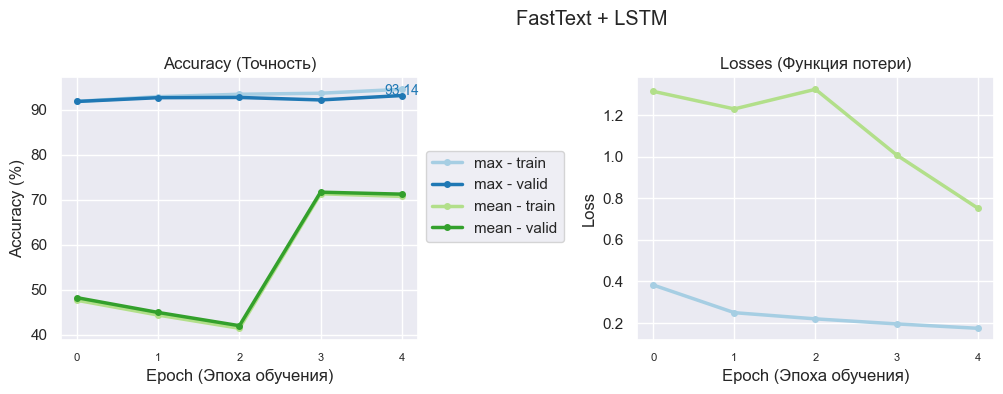

In [60]:
num_epoch = 5
best_eval_acc = float('-inf')
best_model_state = None
save_path = f"best_model_fasttext.pt"
best_params = {'aggregation_type': None, 'epoch': None}

losses_type = {}
acc_type = {}


for aggregation_type in ['max', 'mean']:

    print(f"Обучение для типа аггрегации {aggregation_type}")
    losses = []
    acc = []


    model = FullWordLM_LSTM_upd(
        hidden_dim=256, num_classes=len(labels_dict), 
        aggregation_type=aggregation_type
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Цикл по эпохам
    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()

        # Проход по батчам данных
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Эпоха обучения {epoch}')):
            optimizer.zero_grad()

            # Передаем токены и числовые признаки в модель
            logits = model({
                'embeddings': batch['embeddings'],
                'duration': batch['duration'],
                'sum': batch['sum']
            })

            # Вычисляем потери
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())


        model.eval()
        current_accuracy_valid,_ = evaluate_upd(model, eval_dataloader)
        current_accuracy_train,_ = evaluate_upd(model, train_dataloader)

        acc.append([current_accuracy_train, current_accuracy_valid])
        model.train()

        if current_accuracy_valid > best_eval_acc:
            best_eval_acc = current_accuracy_valid
            best_model_state = model.state_dict()
            torch.save(best_model_state, save_path)
            print(f"Лучшая модель сохранена: эпоха {epoch}, valid_accuracy {best_eval_acc:.4f}")
            best_params['aggregation_type'] = aggregation_type
            best_params['epoch'] = epoch

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc


results_viz('FastText + LSTM', num_epoch, acc_type, losses_type, best_params)

In [61]:
model_full_lstm_upd = FullWordLM_LSTM_upd(
        hidden_dim=256, num_classes=len(labels_dict), 
        aggregation_type=best_params['aggregation_type']
    ).to(device)


# save_path = f"best_model.pt"
model_full_lstm_upd.load_state_dict(torch.load(save_path, weights_only=True))
model_full_lstm_upd.eval()

accuracy_valid,_ = evaluate_upd(model_full_lstm_upd, eval_dataloader)
accuracy_test, predictions_test = evaluate_upd(model_full_lstm_upd, test_dataloader)



print(f'Точность на валидационной выборке: {accuracy_valid:.4f}')
print(f'Точность на тестовой выборке: {accuracy_test:.4f}')

predictions_test = predictions_test.tolist()
f1_weighted = f1_score(y_test, predictions_test, average='weighted')
print(f'F1(weighted) на тестовой выборке: {f1_weighted:.4f}')

print(f"\nЛучшая модель - лучшие параметры: aggregation_type {best_params['aggregation_type']}, epoch {best_params['epoch']}")


Точность на валидационной выборке: 0.9314
Точность на тестовой выборке: 0.9276
F1(weighted) на тестовой выборке: 0.9280

Лучшая модель - лучшие параметры: aggregation_type max, epoch 4


In [62]:
results.loc[len(results)] = [
    'Модель LSTM',
    'FastText + LSTM. Использование valid',
    accuracy_valid,
    accuracy_test,
    f1_weighted,
    best_params
]
results

,Модель,Детали (описание модели),Accuracy_valid,Accuracy_test,F1_test,Best_params
0,Baseline,TF-IDF + Логистическая регрессия (OneVsRestClassifier),0.922840,0.920728,0.920702,None
1,Модель 2,TfIdf + RandomForest. Обучение на train,0.924626,0.921378,0.921521,None
2,Модель 3,BoW + RandomForest. Обучение на train,0.925601,0.922677,0.922813,None
3,Модель RNN,Свой словарь + RNN. Использование valid,0.926901,0.914392,0.914336,"{'aggregation_type': 'max', 'epoch': 2}"
4,Модель LSTM,Свой словарь + LSTM. Использование valid,0.936810,0.925601,0.925499,"{'aggregation_type': 'max', 'epoch': 4}"
5,Модель LSTM,FastText + LSTM. Использование valid,0.931449,0.927550,0.927957,"{'aggregation_type': 'max', 'epoch': 4}"


Использование предобученных эмбеддингов вместо нашего словаря улучшило качество модели. Однако можно попробовать еще добавить лемматизацию слов

### 5.5.2. FastText + лемматизация Mystem + LSTM

pymystem3 — это библиотека Python, которая предоставляет доступ к морфологическому анализатору MyStem от Яндекса

In [63]:
from pymystem3 import Mystem

In [64]:
import fasttext
import torch
import re
from torch.utils.data import Dataset
from pymystem3 import Mystem

class ModifiedDatasetFTlemm(Dataset):
    def __init__(self, data, embedding_model, has_labels=True):
        self.data = data
        self.model = embedding_model
        self.has_labels = has_labels
        self.mystem = Mystem()

    def lemmatize_text(self, text):
        lemmas = self.mystem.lemmatize(text)
        return [lemma for lemma in lemmas if lemma.strip()]

    def get_word_embedding(self, word):
        # Получаем эмбеддинг для слова
        embedding = self.model.get_word_vector(word)
        return torch.tensor(embedding)

    def __getitem__(self, idx: int) -> dict:
        text = self.data[idx]['text'].lower()
        text = re.sub(r'[^\w\s]', ' ', text) 

        lemmatized_words = self.lemmatize_text(text)
        
        embeddings = []
        for word in lemmatized_words:
            embedding = self.get_word_embedding(word)
            embeddings.append(embedding)

        if self.has_labels:
            train_sample = {
                "embeddings": torch.stack(embeddings), 
                "label": self.data[idx]['label'],
                "duration": self.data[idx]['duration'],  
                "sum": self.data[idx]['sum']  
            }
        else:
            train_sample = {
                "duration": self.data[idx]['duration'],  
                "sum": self.data[idx]['sum']  
            }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)

def collate_fn_with_padding(input_batch, max_len=256):
    seq_lens = [len(x['embeddings']) for x in input_batch]
    max_seq_len = min(max(max_len, max(seq_lens)), max_len)

    padded_batch_embeddings = []
    new_batch_duration = []
    new_batch_sum = []
    labels = []

    for i, sequence in enumerate(input_batch):
        embeddings = sequence['embeddings'][:max_seq_len]
        padding_size = max_seq_len - len(embeddings)
        embeddings = torch.cat([embeddings, torch.zeros((padding_size, embeddings.size(1)))])  

        padded_batch_embeddings.append(embeddings)
        new_batch_duration.append(sequence['duration'])
        new_batch_sum.append(sequence['sum'])

        if 'label' in sequence:
            labels.append(sequence['label'])

    embeddings_tensor = torch.stack(padded_batch_embeddings).to(device)
    durations_tensor = torch.FloatTensor(new_batch_duration).to(device)
    sums_tensor = torch.FloatTensor(new_batch_sum).to(device)

    if labels:
        labels_tensor = torch.LongTensor(labels).to(device)
        return {
            'embeddings': embeddings_tensor,
            'duration': durations_tensor,
            'sum': sums_tensor,
            'label': labels_tensor
        }
    else:
        return {
            'embeddings': embeddings_tensor,
            'duration': durations_tensor,
            'sum': sums_tensor
        }


In [65]:
from sklearn.model_selection import train_test_split
train_dataset, valid_dataset = train_test_split(df0.drop(columns=['okpd']), test_size=0.2, shuffle = True, random_state = 33)
valid_dataset, test_dataset = train_test_split(valid_dataset, test_size=0.5, random_state = 33)

print('Обучающая выборка, train_dataset: ', train_dataset.shape)
print('Валидационная выборка, valid_dataset: ', valid_dataset.shape)
print('Тестовая выборка, test_dataset: ', test_dataset.shape)


train_dataset = ModifiedDatasetFTlemm(train_dataset.to_dict(orient='records'), fasttext_model)
eval_dataset = ModifiedDatasetFTlemm(valid_dataset.to_dict(orient='records'), fasttext_model)
test_dataset = ModifiedDatasetFTlemm(test_dataset.to_dict(orient='records'), fasttext_model)

batch_size = 32
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

Обучающая выборка, train_dataset:  (49245, 4)
Валидационная выборка, valid_dataset:  (6156, 4)
Тестовая выборка, test_dataset:  (6156, 4)


Обучение для типа аггрегации max


Эпоха обучения 0:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 0, valid_accuracy 0.9198


Эпоха обучения 1:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 2:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 2, valid_accuracy 0.9321


Эпоха обучения 3:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая модель сохранена: эпоха 3, valid_accuracy 0.9366


Эпоха обучения 4:   0%|          | 0/1539 [00:00<?, ?it/s]

Обучение для типа аггрегации mean


Эпоха обучения 0:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 1:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 2:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 3:   0%|          | 0/1539 [00:00<?, ?it/s]

Эпоха обучения 4:   0%|          | 0/1539 [00:00<?, ?it/s]

Лучшая accuracy для подхода max: 93.66 valid, 94.79 train
Лучшая accuracy для подхода mean: 91.52 valid, 91.43 train


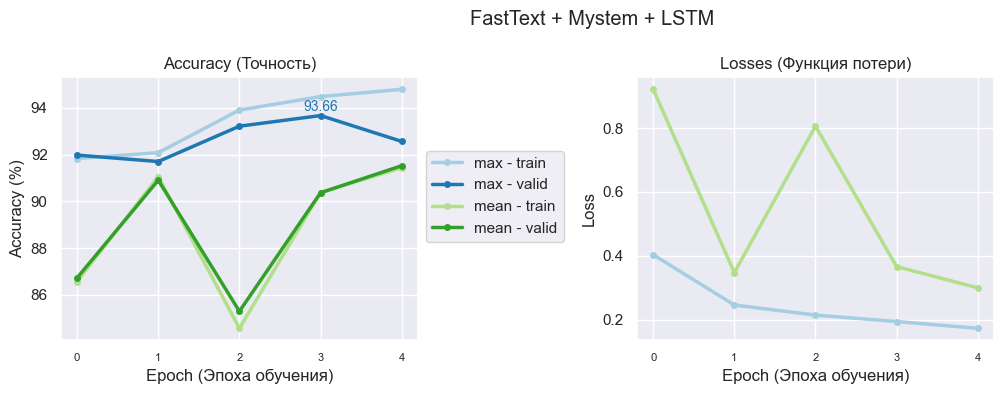

In [66]:
num_epoch = 5
best_eval_acc = float('-inf')
best_model_state = None
save_path = f"best_model_fasttext_lemm.pt"
best_params = {'aggregation_type': None, 'epoch': None}

losses_type = {}
acc_type = {}


#for aggregation_type in ['max', 'mean']:
for aggregation_type in ['max', 'mean']:

    print(f"Обучение для типа аггрегации {aggregation_type}")
    losses = []
    acc = []


    model = FullWordLM_LSTM_upd(
        hidden_dim=256, num_classes=len(labels_dict), 
        aggregation_type=aggregation_type
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()

        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Эпоха обучения {epoch}')):
            optimizer.zero_grad()

            logits = model({
                'embeddings': batch['embeddings'],
                'duration': batch['duration'],
                'sum': batch['sum']
            })

            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())


        model.eval()
        current_accuracy_valid,_ = evaluate_upd(model, eval_dataloader)
        current_accuracy_train,_ = evaluate_upd(model, train_dataloader)

        acc.append([current_accuracy_train, current_accuracy_valid])
        model.train()

        if current_accuracy_valid > best_eval_acc:
            best_eval_acc = current_accuracy_valid
            best_model_state = model.state_dict()
            torch.save(best_model_state, save_path)
            print(f"Лучшая модель сохранена: эпоха {epoch}, valid_accuracy {best_eval_acc:.4f}")
            best_params['aggregation_type'] = aggregation_type
            best_params['epoch'] = epoch

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

results_viz('FastText + Mystem + LSTM', num_epoch, acc_type, losses_type, best_params)

In [67]:
model_full_lstm_upd_lemm = FullWordLM_LSTM_upd(
        hidden_dim=256, num_classes=len(labels_dict), 
        aggregation_type=best_params['aggregation_type']
    ).to(device)


# save_path = f"best_model.pt"
model_full_lstm_upd_lemm.load_state_dict(torch.load(save_path, weights_only=True))
model_full_lstm_upd_lemm.eval()

accuracy_valid,_ = evaluate_upd(model_full_lstm_upd_lemm, eval_dataloader)
accuracy_test, predictions_test = evaluate_upd(model_full_lstm_upd_lemm, test_dataloader)



print(f'Точность на валидационной выборке: {accuracy_valid:.4f}')
print(f'Точность на тестовой выборке: {accuracy_test:.4f}')

predictions_test = predictions_test.tolist()
f1_weighted = f1_score(y_test, predictions_test, average='weighted')
print(f'F1(weighted) на тестовой выборке: {f1_weighted:.4f}')

print(f"\nЛучшая модель - лучшие параметры: aggregation_type {best_params['aggregation_type']}, epoch {best_params['epoch']}")


Точность на валидационной выборке: 0.9366
Точность на тестовой выборке: 0.9293
F1(weighted) на тестовой выборке: 0.9294

Лучшая модель - лучшие параметры: aggregation_type max, epoch 3


In [69]:
results.loc[len(results)] = [
    'Модель LSTM',
    'FastText + Mystem + LSTM. Использование valid',
    accuracy_valid,
    accuracy_test,
    f1_weighted,
    best_params
]
results

,Модель,Детали (описание модели),Accuracy_valid,Accuracy_test,F1_test,Best_params
0,Baseline,TF-IDF + Логистическая регрессия (OneVsRestClassifier),0.922840,0.920728,0.920702,None
1,Модель 2,TfIdf + RandomForest. Обучение на train,0.924626,0.921378,0.921521,None
2,Модель 3,BoW + RandomForest. Обучение на train,0.925601,0.922677,0.922813,None
3,Модель RNN,Свой словарь + RNN. Использование valid,0.926901,0.914392,0.914336,"{'aggregation_type': 'max', 'epoch': 2}"
4,Модель LSTM,Свой словарь + LSTM. Использование valid,0.936810,0.925601,0.925499,"{'aggregation_type': 'max', 'epoch': 4}"
5,Модель LSTM,FastText + LSTM. Использование valid,0.931449,0.927550,0.927957,"{'aggregation_type': 'max', 'epoch': 4}"
6,Модель LSTM,FastText + Mystem + LSTM. Использование valid,0.936647,0.929337,0.929435,"{'aggregation_type': 'max', 'epoch': 3}"


# 6. Заключение

В ходе данной работы были попробованы разные подходы к обработке текста, разные типы моделей, разные архитектуры, в том числе сложные реккурентные нейронные сети.

Модели на основе нейронных сетей (RNN, LSTM) показали лучшие результаты по сравнению с традиционными моделями машинного обучения (логистическая регрессия и RandomForest), особенно при использовании FastText и Mystem.

Лучшая модель — это LSTM с FastText и Mystem, что свидетельствует о важности использования предобученных эмбеддингов и морфологического анализа для улучшения качества предсказаний (Последняя модель с FastText, лемматизацией и LSTM слоями показала наилучший результат по метрике качества accuracy, f1 на тестовом датасете). Однако, такая модель требует значительных вычислительных ресурсов. В том числе использование модели FastText с большим объемом данных по предобученным эмбеддингам (около 4Гб загруженных эмбеддингов) делают абсолютно невозможным разворачивание этой модели на бесплатных аккаунтов сервисов render.com и тд в учебных целях

Тем не менее, остальные модели прекрасно справились с поставленной задачей. Разница в accuracy составляет около 1% от лучшей модели, что указывает на то, что более простые модели с меньшими требованиями к ресурсам также могут давать достойные результаты при правильной настройке и обработке данных.



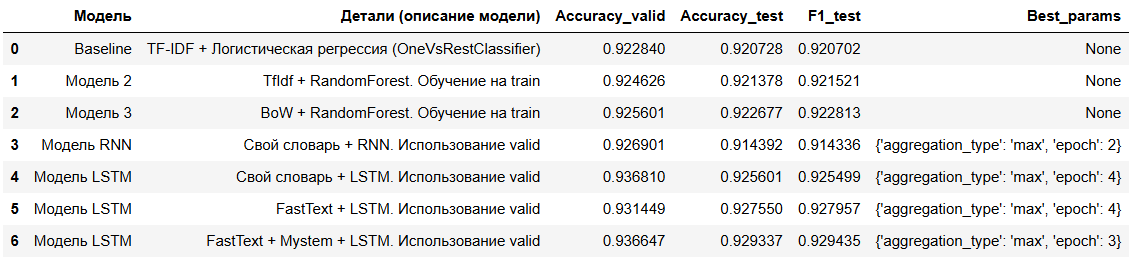